# 📊 BEP Performance Evaluation: SQLite vs MongoDB

This notebook benchmarks query execution time across SQLite and MongoDB using the OpenFDA dataset.


---

## 📦 1. Setup

In [68]:
import time
import sqlite3
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# SQLite
sqlite_path = "../sql/openfda_final_v3.db"
sqlite_conn = sqlite3.connect(sqlite_path)
sqlite_cursor = sqlite_conn.cursor()

# MongoDB
mongo_client = MongoClient("mongodb://localhost:27017")
mongo_db = mongo_client["openfda_converted"]
mongo_collection = mongo_db["full_reports"]



# Helper function to time a query
def time_query(func, n_runs=5):
    durations = []
    for _ in range(n_runs):
        start = time.perf_counter()
        func()
        durations.append(time.perf_counter() - start)
    return durations

## 🔍 2. Query Performance Comparison Strategy

### Query Categories:
- **Simple**: Single-table lookups, counts, or filters
- **Medium**: Multi-table joins or filtered aggregates
- **Complex**: Nested logic, joins with filtering, or document traversals

Each query will be:
- Executed multiple times (default: 5 runs)
- Reported as a list of runtimes
- Summarized using mean and standard deviation

---

## 🧪 3. Simple Queries

### --- Query 1: Count All Reports ---

In [5]:
# SQLite
def sqlite_query_count_reports():
    return sqlite_cursor.execute("SELECT COUNT(*) FROM report").fetchone()

sqlite_result = sqlite_query_count_reports()
print("SQLite:", sqlite_result)

# MongoDB
def mongo_query_count_reports():
    return mongo_collection.count_documents({})

mongo_result = mongo_query_count_reports()
print("MongoDB:", mongo_result)


SQLite: (35999,)
MongoDB: 35999


### --- Query 2: List Distinct Drug Names (first 10 alphabetically) ---

In [11]:
# SQLite
def sqlite_query_distinct_drugs():
    return sqlite_cursor.execute("""
        SELECT DISTINCT medicinalproduct
        FROM drug_catalog
        ORDER BY medicinalproduct
    """).fetchall()

sqlite_result = sqlite_query_distinct_drugs()
print(f"SQLite distinct drugs: {len(sqlite_result)} rows")
print("SQLite:", [r[0] for r in sqlite_result[:10]])

# MongoDB
def mongo_query_distinct_drugs():
    pipeline = [
        {"$unwind": "$patient.drug"},
        {"$group": {"_id": "$patient.drug.medicinalproduct"}},
        {"$sort": {"_id": 1}},
    ]
    return [doc["_id"] for doc in mongo_collection.aggregate(pipeline)]

mongo_result = mongo_query_distinct_drugs()
print(f"MongoDB distinct drugs: {len(mongo_result)} rows")
print("MongoDB:", mongo_result[:10])

SQLite distinct drugs: 8214 rows
SQLite: ['.ALPHA.-PYRROLIDINOISOHEXANOPHENONE', '.ALPHA.-TOCOPHEROL', '.ALPHA.-TOCOPHEROL ACETATE', '.ALPHA.-TOCOPHEROL ACETATE, D-', '.ALPHA.-TOCOPHEROL ACETATE, D-\\EVENING PRIMROSE OIL\\FISH OIL', '.ALPHA.-TOCOPHEROL ACETATE, DL-', '.ALPHA.-TOCOPHEROL, D-', '.ALPHA.-TOCOPHEROL, DL-', '.ALPHA.1-PROTEINASE INHIBITOR HUMAN', '.DELTA.8-TETRAHYDROCANNABINOL\\HERBALS']
MongoDB distinct drugs: 8214 rows
MongoDB: ['.ALPHA.-PYRROLIDINOISOHEXANOPHENONE', '.ALPHA.-TOCOPHEROL', '.ALPHA.-TOCOPHEROL ACETATE', '.ALPHA.-TOCOPHEROL ACETATE, D-', '.ALPHA.-TOCOPHEROL ACETATE, D-\\EVENING PRIMROSE OIL\\FISH OIL', '.ALPHA.-TOCOPHEROL ACETATE, DL-', '.ALPHA.-TOCOPHEROL, D-', '.ALPHA.-TOCOPHEROL, DL-', '.ALPHA.1-PROTEINASE INHIBITOR HUMAN', '.DELTA.8-TETRAHYDROCANNABINOL\\HERBALS']


In [15]:
set_sqlite = set([r[0] for r in sqlite_result])
set_mongo = set(mongo_result)
print("SQLite and MongoDB distinct drugs match:", set_sqlite == set_mongo)


SQLite and MongoDB distinct drugs match: True


### --- Query 3: Count Reports Mentioning 'ASPIRIN' ---

In [16]:
# SQLite
def sqlite_query_aspirin_reports():
    return sqlite_cursor.execute("""
        SELECT COUNT(DISTINCT safetyreportid)
        FROM patient_drug_history
        JOIN drug_catalog USING(drug_id)
        WHERE medicinalproduct = 'ASPIRIN'
    """).fetchone()[0]

sqlite_result = sqlite_query_aspirin_reports()
print("SQLite:", sqlite_result)

# MongoDB
def mongo_query_aspirin_reports():
    return mongo_collection.count_documents({
        "patient.drug.medicinalproduct": "ASPIRIN"
    })

mongo_result = mongo_query_aspirin_reports()
print("MongoDB:", mongo_result)

SQLite: 1186
MongoDB: 1186


## 🧩 4. Medium Queries

### --- Query 4: Count of Serious Reports by Year ---

In [18]:
# SQLite
def sqlite_query_serious_by_year():
    return sqlite_cursor.execute("""
        SELECT SUBSTR(receivedate, 1, 4) AS year, COUNT(*) AS count
        FROM report
        WHERE serious = 1
        GROUP BY year
        ORDER BY year
    """).fetchall()

sqlite_result = sqlite_query_serious_by_year()
print("SQLite:", sqlite_result)

# MongoDB
def mongo_query_serious_by_year():
    pipeline = [
        {"$match": {"serious": 1}},
        {"$project": {"year": {"$substr": ["$receivedate", 0, 4]}}},
        {"$group": {"_id": "$year", "count": {"$sum": 1}}},
        {"$sort": {"_id": 1}}
    ]
    return list(mongo_collection.aggregate(pipeline))

mongo_result = mongo_query_serious_by_year()
print("MongoDB:", [(d["_id"], d["count"]) for d in mongo_result])

SQLite: [('2007', 2), ('2008', 2), ('2010', 3), ('2012', 2), ('2013', 1), ('2014', 8), ('2015', 21), ('2016', 48), ('2017', 61), ('2018', 85), ('2019', 151), ('2020', 238), ('2021', 417), ('2022', 840), ('2023', 4016), ('2024', 14480)]
MongoDB: [('2007', 2), ('2008', 2), ('2010', 3), ('2012', 2), ('2013', 1), ('2014', 8), ('2015', 21), ('2016', 48), ('2017', 61), ('2018', 85), ('2019', 151), ('2020', 238), ('2021', 417), ('2022', 840), ('2023', 4016), ('2024', 14480)]


In [20]:
# --- Query 5: Top 5 Most Frequently Reported Reactions ---
# 🧪 Step 1: Run once and inspect output

# SQLite
def sqlite_query_top_reactions():
    return sqlite_cursor.execute("""
        SELECT reactionmeddrapt, COUNT(*) AS count
        FROM reaction
        GROUP BY reactionmeddrapt
        ORDER BY count DESC
    """).fetchall()

sqlite_result = sqlite_query_top_reactions()
print(f"SQLite top reactions: {len(sqlite_result)} rows")
print("SQLite:", sqlite_result[:5])


# MongoDB
def mongo_query_top_reactions():
    pipeline = [
        {"$unwind": "$patient.reaction"},
        {"$group": {"_id": "$patient.reaction.reactionmeddrapt", "count": {"$sum": 1}}},
        {"$sort": {"count": -1}},
    ]
    return list(mongo_collection.aggregate(pipeline))

mongo_result = mongo_query_top_reactions()
print(f"MongoDB top reactions: {len(mongo_result)} rows")
print("MongoDB:", [(d["_id"], d["count"]) for d in mongo_result[:5]])


SQLite top reactions: 6110 rows
SQLite: [('Off label use', 2872), ('Drug ineffective', 2170), ('Fatigue', 1707), ('Nausea', 1531), ('Diarrhoea', 1470)]
MongoDB top reactions: 6110 rows
MongoDB: [('Off label use', 2872), ('Drug ineffective', 2170), ('Fatigue', 1707), ('Nausea', 1531), ('Diarrhoea', 1470)]


In [ ]:
# --- Query 6: Average Patient Weight by Age Group ---
# 🧪 Step 1: Run once and inspect output

# SQLite
def sqlite_query_avg_weight_by_agegroup():
    return sqlite_cursor.execute("""
        SELECT ag.patientagegroup, AVG(w.patientweight) AS avg_weight
        FROM patient_age_group ag
        JOIN patient_weight w ON ag.safetyreportid = w.safetyreportid
        GROUP BY ag.patientagegroup
        ORDER BY ag.patientagegroup
    """).fetchall()

sqlite_result = sqlite_query_avg_weight_by_agegroup()
print("SQLite:", sqlite_result)

# MongoDB
def mongo_query_avg_weight_by_agegroup():
    pipeline = [
        {"$match": {
            "patient.patientagegroup": {"$ne": None},
            "patient.patientweight": {"$ne": None}
        }},
        {"$group": {
            "_id": "$patient.patientagegroup",
            "avg_weight": {"$avg": "$patient.patientweight"}
        }},
        {"$sort": {"_id": 1}}
    ]
    return list(mongo_collection.aggregate(pipeline))

mongo_result = mongo_query_avg_weight_by_agegroup()
print("MongoDB:", [(d["_id"], d["avg_weight"]) for d in mongo_result])


SQLite: [(1, 1.82805), (2, 8.067875), (3, 25.309325581395345), (4, 61.58215625), (5, 81.5316234626301), (6, 74.49267149220489)]
MongoDB: [(1, 1.82805), (2, 8.067875), (3, 25.309325581395345), (4, 61.58215625), (5, 81.5316234626301), (6, 74.49267149220489)]


## 🧠 5. Complex Queries

### --- Query Q7: Top drugs by suspect role count ---

In [23]:
# SQLite
def sqlite_query_top_suspect_drugs():
    return sqlite_cursor.execute("""
        SELECT dc.medicinalproduct, COUNT(*) AS suspect_count
        FROM patient_drug_history pdh
        JOIN drug_catalog dc ON pdh.drug_id = dc.drug_id
        WHERE pdh.drugcharacterization = 1
        GROUP BY dc.medicinalproduct
        ORDER BY suspect_count DESC
    """).fetchall()

sqlite_result = sqlite_query_top_suspect_drugs()
print(f"SQLite top suspect drugs: {len(sqlite_result)} rows")
print("SQLite:", sqlite_result[:10])

# MongoDB:
def mongo_query_top_suspect_drugs():
    pipeline = [
        {"$unwind": "$patient.drug"},
        {"$match": {"patient.drug.drugcharacterization": 1}},
        {"$group": {"_id": "$patient.drug.medicinalproduct", "count": {"$sum": 1}}},
        {"$sort": {"count": -1}},
    ]
    return list(mongo_collection.aggregate(pipeline))

mongo_result = mongo_query_top_suspect_drugs()
print(f"MongoDB top suspect drugs: {len(mongo_result)} rows")
print("MongoDB:", [(d["_id"], d["count"]) for d in mongo_result[:10]])


SQLite top suspect drugs: 3874 rows
SQLite: [('MOUNJARO', 10153), ('DUPIXENT', 3670), ('INFLECTRA', 2556), ('REPATHA', 1769), ('METHOTREXATE', 1666), ('RITUXIMAB', 1322), ('PREDNISONE', 1274), ('VEDOLIZUMAB', 1223), ('ZEPBOUND', 1123), ('POMALYST', 1006)]
MongoDB top suspect drugs: 3874 rows
MongoDB: [('MOUNJARO', 10153), ('DUPIXENT', 3670), ('INFLECTRA', 2556), ('REPATHA', 1769), ('METHOTREXATE', 1666), ('RITUXIMAB', 1322), ('PREDNISONE', 1274), ('VEDOLIZUMAB', 1223), ('ZEPBOUND', 1123), ('POMALYST', 1006)]


### --- Query Q8: Average number of reactions per report per year ---

In [24]:
# SQLite:

def sqlite_query_avg_reactions_by_year():
    return sqlite_cursor.execute("""
        SELECT SUBSTR(r.receivedate, 1, 4) AS year, AVG(rx.count) AS avg_reactions
        FROM report r
        JOIN (
            SELECT safetyreportid, COUNT(*) AS count
            FROM reaction
            GROUP BY safetyreportid
        ) rx ON r.safetyreportid = rx.safetyreportid
        GROUP BY year
        ORDER BY year
    """).fetchall()

sqlite_result = sqlite_query_avg_reactions_by_year()
print("SQLite:", sqlite_result)

# MongoDB:

def mongo_query_avg_reactions_by_year():
    pipeline = [
        {"$project": {
            "year": {"$substr": ["$receivedate", 0, 4]},
            "reaction_count": {"$size": {"$ifNull": ["$patient.reaction", []]}}
        }},
        {"$group": {"_id": "$year", "avg_reactions": {"$avg": "$reaction_count"}}},
        {"$sort": {"_id": 1}}
    ]
    return list(mongo_collection.aggregate(pipeline))

mongo_result = mongo_query_avg_reactions_by_year()
print("MongoDB:", [(d["_id"], d["avg_reactions"]) for d in mongo_result])

SQLite: [('2007', 1.0), ('2008', 3.0), ('2010', 2.3333333333333335), ('2012', 11.5), ('2013', 3.0), ('2014', 7.4), ('2015', 8.130434782608695), ('2016', 6.290909090909091), ('2017', 8.505494505494505), ('2018', 7.4), ('2019', 9.564516129032258), ('2020', 11.808724832214764), ('2021', 7.774137931034483), ('2022', 5.767915844838922), ('2023', 4.513021909880115), ('2024', 2.8027689689844535)]
MongoDB: [('2007', 1.0), ('2008', 3.0), ('2010', 2.3333333333333335), ('2012', 11.5), ('2013', 3.0), ('2014', 7.4), ('2015', 8.130434782608695), ('2016', 6.290909090909091), ('2017', 8.505494505494505), ('2018', 7.4), ('2019', 9.564516129032258), ('2020', 11.808724832214764), ('2021', 7.774137931034483), ('2022', 5.767915844838922), ('2023', 4.513021909880115), ('2024', 2.8027689689844535)]


### --- Query Q9: Literature references for serious ASPIRIN reports ---

In [26]:
# SQLite:

def sqlite_query_litrefs_serious_aspirin():
    return sqlite_cursor.execute("""
        SELECT DISTINCT pr.literature_reference
        FROM report r
        JOIN patient_drug_history pdh ON r.safetyreportid = pdh.safetyreportid
        JOIN drug_catalog dc ON pdh.drug_id = dc.drug_id
        JOIN primarysource_literature_reference pr ON r.safetyreportid = pr.safetyreportid
        WHERE dc.medicinalproduct = 'ASPIRIN' AND r.serious = 1
    """).fetchall()

sqlite_result = sqlite_query_litrefs_serious_aspirin()
print("SQLite:", sqlite_result)
print("SQLite count:", len(sqlite_result))

# MongoDB:

def mongo_query_litrefs_serious_aspirin():
    pipeline = [
        {"$match": {"serious": 1, "patient.drug.medicinalproduct": "ASPIRIN"}},
        {"$project": {"primarysource.literaturereference": 1}},
        {"$unwind": "$primarysource.literaturereference"},
        {"$group": {"_id": "$primarysource.literaturereference"}}
    ]
    return list(mongo_collection.aggregate(pipeline))

mongo_result = mongo_query_litrefs_serious_aspirin()
print("MongoDB:", [d["_id"] for d in mongo_result])
print("MongoDB count:", len(mongo_result))

SQLite: [('David D. Gummin, James B. Mowry, Michael C. Beuhler, Daniel A. Spyker, Laura J. Rivers, Ryan Feldman, Kaitlyn Brown, Nathaniel P.T. Pham, Alvin C. Bronstein and Carol DesLauriers. 2022 Annual Report of the National Poison Data System?  (NPDS) from America?s Poison Centers? : 40th Annual Report. Clinical Toxicology. 2023;61:10:717-939,',), ('David D. Gummin, James B. Mowry, Michael C. Beuhler, Daniel A. Spyker, Laura J. Rivers, Ryan Feldman, Kaitlyn Brown, Nathaniel P.T. Pham, Alvin C. Bronstein and Carol DesLauriers. 2022 Annual Report of the National Poison Data System?  (NPDS) from America?s Poison Centers? : 40th Annual Report. Clinical Toxicology. 2023;61:10:717-939',), ('Hennawi AH, Lakhani S, Khan SI, Atam S, Sadiq U, Rigotti J, et al. Dipyridamole-induced STEMI: case report and review of the literature. Glob Cardiol Sci Pract. 2023;3: UNKNOWN-UNKNOWN. doi:UNKNOWN.',), ('Senel AS, Denizhan TK, Kiziltepe M, Kokoglu EO, Tutar N. Recurrent spontaneous pneumothorax under n

In [27]:
sqlite_result_set = set([r[0] for r in sqlite_result])
mongo_result_set = set([d["_id"] for d in mongo_result])
print("SQLite and MongoDB literature references match:", sqlite_result_set == mongo_result_set)

SQLite and MongoDB literature references match: True


### --- Query Q10: Top 10 drugs most frequently associated with “DEATH” reactions

In [ ]:
# # SQLite

# def sqlite_query_top_10_deadly():
#     return sqlite_cursor.execute("""
#         SELECT dc.medicinalproduct, COUNT(*) AS count
#         FROM patient_drug_history pdh
#         JOIN drug_catalog dc ON pdh.drug_id = dc.drug_id
#         JOIN reaction r ON r.safetyreportid = pdh.safetyreportid
#         WHERE r.reactionmeddrapt LIKE '%DEATH%'
#         GROUP BY dc.medicinalproduct
#         ORDER BY count DESC
#     """).fetchall()

# sqlite_result = sqlite_query_top_10_deadly()
# print("SQLite:", sqlite_result[:10])
# print("SQLite count:", len(sqlite_result))



# def mongo_query_top_10_deadly():
#     pipeline = [
#         {"$unwind": "$patient.reaction"},
#         {"$match": {"patient.reaction.reactionmeddrapt": {"$regex": "Death"}}},
#         {"$unwind": "$patient.drug"},
#         {"$group": {"_id": "$patient.drug.medicinalproduct", "count": {"$sum": 1}}},
#         {"$sort": {"count": -1}},
#     ]
#     return list(mongo_collection.aggregate(pipeline))
# mongo_result = mongo_query_top_10_deadly()
# # print("MongoDB:", [(d["_id"], d["count"]) for d in mongo_result[:10]])
# print("MongoDB:", mongo_result[:10])
# print("MongoDB count:", len(mongo_result))

SQLite: [('HYDROMORPHONE HYDROCHLORIDE', 99), ('RITUXIMAB', 98), ('ONDANSETRON', 93), ('ELIGARD', 92), ('METHOTREXATE', 85), ('NUPLAZID', 83), ('POMALYST', 82), ('OFEV', 80), ('PREDNISONE', 79), ('ACETAMINOPHEN', 77)]
SQLite count: 1560
MongoDB: [{'_id': 'ELIGARD', 'count': 92}, {'_id': 'HYDROMORPHONE HYDROCHLORIDE', 'count': 90}, {'_id': 'ONDANSETRON', 'count': 89}, {'_id': 'NUPLAZID', 'count': 83}, {'_id': 'POMALYST', 'count': 82}, {'_id': 'METHOTREXATE', 'count': 82}, {'_id': 'OFEV', 'count': 78}, {'_id': 'PREDNISONE', 'count': 77}, {'_id': 'ELIQUIS', 'count': 68}, {'_id': 'ACETAMINOPHEN', 'count': 67}]
MongoDB count: 1460


In [47]:
# --- Query Q10 (Revised): Reactions in Death-Associated Reports ---
# 🧪 Step 1: Run once and inspect output

# SQLite
def sqlite_query_reactions_with_death_flag():
    return sqlite_cursor.execute("""
        SELECT r.reactionmeddrapt, COUNT(*) AS count
        FROM report rep
        JOIN reaction r ON rep.safetyreportid = r.safetyreportid
        WHERE rep.seriousnessdeath = 1
        GROUP BY r.reactionmeddrapt
        ORDER BY count DESC
    """).fetchall()

sqlite_result = sqlite_query_reactions_with_death_flag()
print("SQLite:", sqlite_result[:10])
print("SQLite count:", len(sqlite_result))

# MongoDB
def mongo_query_reactions_with_death_flag():
    pipeline = [
        {"$match": {"seriousnessdeath": 1}},
        {"$unwind": "$patient.reaction"},
        {"$group": {"_id": "$patient.reaction.reactionmeddrapt", "count": {"$sum": 1}}},
        {"$sort": {"count": -1}},
    ]
    return list(mongo_collection.aggregate(pipeline))

mongo_result = mongo_query_reactions_with_death_flag()
print("MongoDB:", [(d["_id"], d["count"]) for d in mongo_result[:10]])
print("MongoDB count:", len(mongo_result))


SQLite: [('Death', 1282), ('Completed suicide', 218), ('Off label use', 205), ('Toxicity to various agents', 198), ('Drug abuse', 169), ('Pneumonia', 117), ('Drug ineffective', 96), ('Diarrhoea', 84), ('Sepsis', 82), ('Nausea', 80)]
SQLite count: 1700
MongoDB: [('Death', 1282), ('Completed suicide', 218), ('Off label use', 205), ('Toxicity to various agents', 198), ('Drug abuse', 169), ('Pneumonia', 117), ('Drug ineffective', 96), ('Diarrhoea', 84), ('Sepsis', 82), ('Dyspnoea', 80)]
MongoDB count: 1700


### 🔴 FOR THE FUTURE. Distribution of serious reports per route of drug

In [49]:
# # SQLite Querie

# def sqlite_query_dist_serious_route():
#     return sqlite_cursor.execute("""
#         SELECT o.route, COUNT(DISTINCT r.safetyreportid) AS serious_count
#         FROM report r
#         JOIN patient_drug_history pdh ON r.safetyreportid = pdh.safetyreportid
#         JOIN drug_openfda o ON pdh.drug_id = o.drug_id
#         WHERE r.serious = 1
#         GROUP BY o.route
#         ORDER BY serious_count DESC
#     """).fetchall()

# sqlite_result = sqlite_query_dist_serious_route()
# print("SQLite:", sqlite_result[:10])
# print("SQLite count:", len(sqlite_result))

# def mongo_query_dist_serious_route():
#     pipeline = [
#         {"$match": {"serious": 1}},
#         {"$unwind": "$patient.drug"},
#         {"$group": {
#             "_id": "$patient.drug.openfda.route",
#             "count": {"$sum": 1}
#         }},
#         {"$sort": {"count": -1}}
#     ]
#     return list(mongo_collection.aggregate(pipeline))
# mongo_result = mongo_query_dist_serious_route()
# print("MongoDB:", [(d["_id"], d["count"]) for d in mongo_result[:10]])
# print("MongoDB count:", len(mongo_result))


SQLite: [('ORAL', 13777), ('INTRAVENOUS', 5207), ('SUBCUTANEOUS', 2934), ('INTRAVENOUS, ORAL', 2206), ('ORAL, INTRAVENOUS', 2041), ('ORAL, INTRAMUSCULAR, INTRAVENOUS', 1377), ('ORAL, RECTAL', 1116), ('ORAL, RECTAL, INTRAVENOUS', 1054), ('SUBCUTANEOUS, INTRAVENOUS', 990), ('INTRAVENOUS, SUBCUTANEOUS', 917)]
SQLite count: 242
MongoDB: [(['ORAL'], 50564), (None, 24667), (['INTRAVENOUS'], 15265), (['SUBCUTANEOUS'], 6651), (['ORAL', 'INTRAVENOUS'], 3441), (['INTRAVENOUS', 'ORAL'], 3129), (['INTRAVENOUS', 'SUBCUTANEOUS'], 2818), (['SUBCUTANEOUS', 'INTRAVENOUS'], 2743), (['ORAL', 'INTRAMUSCULAR', 'INTRAVENOUS'], 2032), (['ORAL', 'INTRAMUSCULAR', 'INTRAVENOUS', 'SUBCUTANEOUS', 'INTRATHECAL', 'INTRA-ARTERIAL'], 1982)]
MongoDB count: 242


In [51]:
# SQLite Querie

# def sqlite_query_dist_serious_route():
#     return sqlite_cursor.execute("""
#         SELECT o.route, COUNT(DISTINCT r.safetyreportid) AS serious_count
#         FROM report r
#         JOIN patient_drug_history pdh ON r.safetyreportid = pdh.safetyreportid
#         JOIN drug_openfda o ON pdh.drug_id = o.drug_id
#         WHERE r.serious = 1
#         GROUP BY o.route
#         ORDER BY serious_count DESC
#     """).fetchall()

# sqlite_result = sqlite_query_dist_serious_route()
# print("SQLite:", sqlite_result[:10])
# print("SQLite count:", len(sqlite_result))

# def mongo_query_dist_serious_route():
#     pipeline = [
#         {"$match": {"serious": 1}},
#         {"$unwind": "$patient.drug"},
#         {"$unwind": "$patient.drug.openfda.route"},
#         {"$group": {
#             "_id": {
#                 "report_id": "$safetyreportid",
#                 "route": "$patient.drug.openfda.route"
#             }
#         }},
#         {"$group": {
#             "_id": "$_id.route",
#             "count": {"$sum": 1}
#         }},
#         {"$sort": {"count": -1}}
#     ]
#     return list(mongo_collection.aggregate(pipeline))
# mongo_result = mongo_query_dist_serious_route()
# print("MongoDB:", [(d["_id"], d["count"]) for d in mongo_result[:50]])
# print("MongoDB count:", len(mongo_result))


SQLite: [('ORAL', 13777), ('INTRAVENOUS', 5207), ('SUBCUTANEOUS', 2934), ('INTRAVENOUS, ORAL', 2206), ('ORAL, INTRAVENOUS', 2041), ('ORAL, INTRAMUSCULAR, INTRAVENOUS', 1377), ('ORAL, RECTAL', 1116), ('ORAL, RECTAL, INTRAVENOUS', 1054), ('SUBCUTANEOUS, INTRAVENOUS', 990), ('INTRAVENOUS, SUBCUTANEOUS', 917)]
SQLite count: 242
MongoDB: [('ORAL', 16122), ('INTRAVENOUS', 11007), ('SUBCUTANEOUS', 5825), ('INTRAMUSCULAR', 4561), ('TOPICAL', 3183), ('RECTAL', 2700), ('OPHTHALMIC', 2194), ('NASAL', 1462), ('INTRATHECAL', 1446), ('INTRA-ARTERIAL', 1116), ('RESPIRATORY (INHALATION)', 1114), ('TRANSDERMAL', 1036), ('SUBLINGUAL', 1006), ('INTRAVITREAL', 924), ('INTRACANALICULAR', 765), ('CUTANEOUS', 683), ('EXTRACORPOREAL', 505), ('BUCCAL', 409), ('PARENTERAL', 389), ('VAGINAL', 361), ('INTRAVASCULAR', 312), ('EPIDURAL', 296), ('PERCUTANEOUS', 257), ('IRRIGATION', 256), ('AURICULAR (OTIC)', 218), ('INFILTRATION', 188), ('PERINEURAL', 181), ('INTRA-ARTICULAR', 170), ('SUBMUCOSAL', 136), ('INTRAVENTR

In [31]:
sqlite_result_set = set([r[0] for r in sqlite_result])
mongo_result_set = set([d["_id"] for d in mongo_result])
print("SQLite and MongoDB literature references match:", sqlite_result_set == mongo_result_set)

SQLite and MongoDB literature references match: True


### Q11. Count of reports where multiple drugs were marked as "Suspect"

In [32]:
# SQLite Queries
def sqlite_multiple_suspect():
    return sqlite_cursor.execute("""
        SELECT COUNT(*)
        FROM (
            SELECT safetyreportid
            FROM patient_drug_history
            WHERE drugcharacterization = 1
            GROUP BY safetyreportid
            HAVING COUNT(*) > 1
        )

    """).fetchall()

sqlite_result = sqlite_multiple_suspect()
print("SQLite:", sqlite_result)
print("SQLite count:", len(sqlite_result))

def mongo_multiple_suspect():
    pipeline = [
        {"$project": {
            "suspect_count": {
                "$size": {
                    "$filter": {
                        "input": "$patient.drug",
                        "as": "d",
                        "cond": {"$eq": ["$$d.drugcharacterization", 1]}
                    }
                }
            }
        }},
        {"$match": {"suspect_count": {"$gt": 1}}},
        {"$count": "multi_suspect_reports"}
    ]
    return list(mongo_collection.aggregate(pipeline))
mongo_result = mongo_multiple_suspect()
print("MongoDB:", mongo_result)
print("MongoDB count:", len(mongo_result))


SQLite: [(17317,)]
SQLite count: 1
MongoDB: [{'multi_suspect_reports': 17317}]
MongoDB count: 1


### --- Query 12: Drugs NEVER marked as suspect (only concomitant or interacting) ---

In [36]:
# SQLite
def sqlite_query_non_suspect_drugs():
    return sqlite_cursor.execute("""
        SELECT DISTINCT dc.medicinalproduct
        FROM patient_drug_history pdh
        JOIN drug_catalog dc ON pdh.drug_id = dc.drug_id
        WHERE dc.drug_id NOT IN (
            SELECT drug_id
            FROM patient_drug_history
            WHERE drugcharacterization = 1
        )
    """).fetchall()

sqlite_result = sqlite_query_non_suspect_drugs()
print("SQLite:", [r[0] for r in sqlite_result[:10]])
print("SQLite count:", len(sqlite_result))

# MongoDB
def mongo_query_non_suspect_drugs():
    # Phase 1: All suspect drugs
    suspect_drugs = set([
        d["_id"] for d in mongo_collection.aggregate([
            {"$unwind": "$patient.drug"},
            {"$match": {"patient.drug.drugcharacterization": 1}},
            {"$group": {"_id": "$patient.drug.medicinalproduct"}}
        ])
    ])
    # Phase 2: All drugs
    all_drugs = set([
        d["_id"] for d in mongo_collection.aggregate([
            {"$unwind": "$patient.drug"},
            {"$group": {"_id": "$patient.drug.medicinalproduct"}}
        ])
    ])
    # Phase 3: Set difference
    non_suspect_only = sorted(all_drugs - suspect_drugs)
    return non_suspect_only

mongo_result = mongo_query_non_suspect_drugs()
print("MongoDB:", mongo_result[:10])
print("MongoDB count:", len(mongo_result))

SQLite: ['VIT D [VITAMIN D NOS]', 'CLAVULANATE POTASSIUM', 'CAFFEINE CITRATE', 'Atasol', 'ACETAMINOPHEN\\CAFFEINE\\CODEINE PHOSPHATE', 'FIBER LAX', 'GASTER', 'BEECOM', 'PLASMA SOLUTION A', 'PEPCID']
SQLite count: 4340
MongoDB: ['.ALPHA.-TOCOPHEROL ACETATE, D-\\EVENING PRIMROSE OIL\\FISH OIL', '.DELTA.9-TETRAHYDROCANNABINOL\\CANNABIDIOL\\HERBALS', '0mega3', '1-ALPHA LEO', '20/25 Hydrocortothiazide', '3 more diuretics', '7-AMINOCLONAZEPAM', '800 mg Metaxalone', '81 ASPIRIN', 'A-C-D-VITAMIN']
MongoDB count: 4340


In [38]:
sqlite_result_set = set([r[0] for r in sqlite_result])
mongo_result_set = set([d for d in mongo_result])
print("SQLite and MongoDB literature references match:", sqlite_result_set == mongo_result_set)

SQLite and MongoDB literature references match: True


# 📈 6. Summary of Results

###

In [73]:
# List to store results
results = []


def add_result(query_name, db, durations):
    results.append({
        "query": query_name,
        "db": db,
        "mean_time": np.mean(durations),
        "std_time": np.std(durations),
        "run_times": durations
    })


## Easy

### 1

In [74]:
# --- Timing: Count All Reports ---
sqlite_durations = time_query(lambda: sqlite_cursor.execute("SELECT COUNT(*) FROM report").fetchone())
mongo_durations = time_query(lambda: mongo_collection.count_documents({}))

add_result("Q1", "SQLite", sqlite_durations)
add_result("Q1", "MongoDB", mongo_durations)

print("SQLite timings:", sqlite_durations)
print("MongoDB timings:", mongo_durations)

SQLite timings: [0.007949300001200754, 0.006939999999303836, 0.0073072999985015485, 0.007116500000847736, 0.008022300000448013]
MongoDB timings: [0.03572619999977178, 0.015045500000269385, 0.014995699999417411, 0.022139400000014575, 0.02499570000145468]


### 2

In [75]:
# ⏱ Timing: Distinct Drug Names
sqlite_durations = time_query(sqlite_query_distinct_drugs)
mongo_durations = time_query(mongo_query_distinct_drugs)

add_result("Q2", "SQLite", sqlite_durations)
add_result("Q2", "MongoDB", mongo_durations)

print("SQLite timings:", sqlite_durations)
print("MongoDB timings:", mongo_durations)

SQLite timings: [0.010997899997164495, 0.00960809999742196, 0.013034800002060365, 0.011440199999924516, 0.013043999999354128]
MongoDB timings: [0.8837378999996872, 0.698662200000399, 0.6989518000009411, 0.7150236000015866, 0.6735279000022274]


### 3

In [76]:
sqlite_durations = time_query(sqlite_query_aspirin_reports)
mongo_durations = time_query(mongo_query_aspirin_reports)

add_result("Q3", "SQLite", sqlite_durations)
add_result("Q3", "MongoDB", mongo_durations)

print("SQLite timings:", sqlite_durations)
print("MongoDB timings:", mongo_durations)

SQLite timings: [0.08052999999927124, 0.06070790000012494, 0.06514650000099209, 0.058431800000107614, 0.05848599999808357]
MongoDB timings: [0.058874400001514005, 0.06874270000116667, 0.06630059999952209, 0.0581519000006665, 0.06086190000132774]


## Medium

### 4

In [77]:
sqlite_durations = time_query(sqlite_query_serious_by_year)
mongo_durations = time_query(mongo_query_serious_by_year)

add_result("Q4", "SQLite", sqlite_durations)
add_result("Q4", "MongoDB", mongo_durations)

print("SQLite timings:", sqlite_durations)
print("MongoDB timings:", mongo_durations)

SQLite timings: [0.019818799999484327, 0.017363300001306925, 0.02045920000091428, 0.051879300001019146, 0.021566499999607913]
MongoDB timings: [0.07545100000061211, 0.05871649999971851, 0.06583220000175061, 0.0759226000009221, 0.07313069999872823]


### 5

In [78]:
sqlite_durations = time_query(sqlite_query_top_reactions)
mongo_durations = time_query(mongo_query_top_reactions)

add_result("Q5", "SQLite", sqlite_durations)
add_result("Q5", "MongoDB", mongo_durations)

print("SQLite timings:", sqlite_durations)
print("MongoDB timings:", mongo_durations)


SQLite timings: [0.12604110000029323, 0.08351159999801894, 0.07833089999985532, 0.07873810000091908, 0.07638610000140034]
MongoDB timings: [0.16529049999735435, 0.15300850000130595, 0.15257389999896986, 0.1520916000008583, 0.14909840000109398]


### 6

In [79]:
sqlite_durations = time_query(sqlite_query_avg_weight_by_agegroup)
mongo_durations = time_query(mongo_query_avg_weight_by_agegroup)

add_result("Q6", "SQLite", sqlite_durations)
add_result("Q6", "MongoDB", mongo_durations)

print("SQLite timings:", sqlite_durations)
print("MongoDB timings:", mongo_durations)


SQLite timings: [0.004125999999814667, 0.004453900000953581, 0.0038401000019803178, 0.004914500001177657, 0.004230999998981133]
MongoDB timings: [0.08078970000133268, 0.03739120000318508, 0.03329429999939748, 0.032299200000124983, 0.030491599998640595]


## Complex

In [80]:
# q7
sqlite_query_top_suspect_drugs_durations = time_query(sqlite_query_top_suspect_drugs)
mongo_query_top_suspect_drugs_durations = time_query(mongo_query_top_suspect_drugs)

add_result("Q7", "SQLite", sqlite_query_top_suspect_drugs_durations)
add_result("Q7", "MongoDB", mongo_query_top_suspect_drugs_durations)

print("SQLite timings:", sqlite_query_top_suspect_drugs_durations)
print("MongoDB timings:", mongo_query_top_suspect_drugs_durations)


SQLite timings: [0.14006069999959436, 0.08987290000004577, 0.09149849999812432, 0.09047159999681753, 0.09875150000152644]
MongoDB timings: [0.6993412000010721, 0.6995284000004176, 0.7108966000014334, 0.7624722000000475, 0.7010835000000952]


In [81]:
# q8
sqlite_query_avg_reactions_by_year_durations = time_query(sqlite_query_avg_reactions_by_year)
mongo_query_avg_reactions_by_year_durations = time_query(mongo_query_avg_reactions_by_year)

add_result("Q8", "SQLite", sqlite_query_avg_reactions_by_year_durations)
add_result("Q8", "MongoDB", mongo_query_avg_reactions_by_year_durations)

print("SQLite timings:", sqlite_query_avg_reactions_by_year_durations)
print("MongoDB timings:", mongo_query_avg_reactions_by_year_durations)

SQLite timings: [0.14851740000085556, 0.09229740000228048, 0.08580540000184556, 0.08617750000121305, 0.08819099999891478]
MongoDB timings: [0.23936440000034054, 0.23793289999957778, 0.23892649999834248, 0.23472300000139512, 0.2348877000003995]


In [82]:
#Q9
sqlite_query_litrefs_serious_aspirin_durations = time_query(sqlite_query_litrefs_serious_aspirin)
mongo_query_litrefs_serious_aspirin_durations = time_query(mongo_query_litrefs_serious_aspirin)

add_result("Q9", "SQLite", sqlite_query_litrefs_serious_aspirin_durations)
add_result("Q9", "MongoDB", mongo_query_litrefs_serious_aspirin_durations)
print("SQLite timings:", sqlite_query_litrefs_serious_aspirin_durations)
print("MongoDB timings:", mongo_query_litrefs_serious_aspirin_durations)

SQLite timings: [0.23084630000084871, 0.17871650000233785, 0.19053840000196942, 0.18113700000321842, 0.1762377999984892]
MongoDB timings: [0.07512549999955809, 0.07350760000190348, 0.07440549999955692, 0.07387489999746322, 0.07523090000177035]


In [83]:
# q10

sqlite_query_reactions_with_death_flag_durations = time_query(sqlite_query_reactions_with_death_flag)
mongo_query_reactions_with_death_flag_durations = time_query(mongo_query_reactions_with_death_flag)
add_result("Q10", "SQLite", sqlite_query_reactions_with_death_flag_durations)
add_result("Q10", "MongoDB", mongo_query_reactions_with_death_flag_durations)
print("SQLite timings:", sqlite_query_reactions_with_death_flag_durations)
print("MongoDB timings:", mongo_query_reactions_with_death_flag_durations)

SQLite timings: [0.18583650000073249, 0.12066540000159875, 0.12028860000282293, 0.11841949999870849, 0.12173639999673469]
MongoDB timings: [0.038388400000258116, 0.04302810000081081, 0.037836800001969095, 0.038478499998745974, 0.03689049999957206]


In [84]:
# FOR THE FUTURE
# sqlite_query_dist_serious_route_durations = time_query(sqlite_query_dist_serious_route)
# mongo_query_dist_serious_route_durations = time_query(mongo_query_dist_serious_route)

In [85]:
#11
sqlite_query_multiple_suspect_durations = time_query(sqlite_multiple_suspect)
mongo_query_multiple_suspect_durations = time_query(mongo_multiple_suspect)
add_result("Q12", "SQLite", sqlite_query_multiple_suspect_durations)
add_result("Q12", "MongoDB", mongo_query_multiple_suspect_durations)
print("SQLite timings:", sqlite_query_multiple_suspect_durations)
print("MongoDB timings:", mongo_query_multiple_suspect_durations)

SQLite timings: [0.15988730000026408, 0.09244559999933699, 0.09139180000056513, 0.08840699999927892, 0.0902152999988175]
MongoDB timings: [0.3421572000006563, 0.3428392999994685, 0.3394802000002528, 0.3377796999993734, 0.3479594000018551]


### q12

In [86]:
# ⏱ Timing: Non-suspect drugs (Q13)
sqlite_durations = time_query(sqlite_query_non_suspect_drugs)
mongo_durations = time_query(mongo_query_non_suspect_drugs)
add_result("Q13", "SQLite", sqlite_durations)
add_result("Q13", "MongoDB", mongo_durations)
print("SQLite timings:", sqlite_durations)
print("MongoDB timings:", mongo_durations)


SQLite timings: [0.22326889999749255, 0.15952330000072834, 0.1547510999989754, 0.1548462999999174, 0.15951199999835808]
MongoDB timings: [1.5416552999995474, 1.472573499999271, 1.339214899999206, 1.4025678999969386, 1.2826067000023613]


### Agregate results

In [87]:
df_results = pd.DataFrame(results)
df_results.to_csv("../reports/evaluation_results/query_performance.csv", index=False)
print("Results saved to evaluation_query_performance.csv")

Results saved to evaluation_query_performance.csv


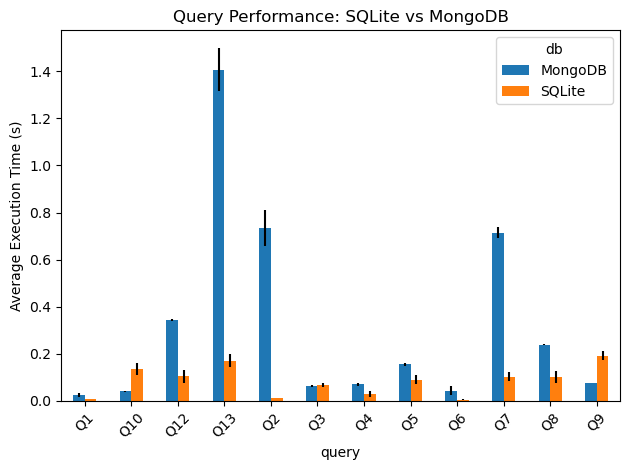

In [ ]:
df = pd.DataFrame(results)



# Pivot for bar chart
pivot = df.pivot(index="query", columns="db", values="mean_time")
pivot.plot(kind="bar", yerr=df.pivot(index="query", columns="db", values="std_time"))



plt.ylabel("Average Execution Time (s)")
plt.title("Query Performance: SQLite vs MongoDB")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


,Query,SQLite Time (s),MongoDB Time (s),% Faster (SQLite)
0,Q1,0.007,0.023,66.931
1,Q10,0.133,0.039,-242.688
2,Q12,0.104,0.342,69.457
3,Q13,0.170,1.408,87.897
4,Q2,0.012,0.734,98.416
5,Q3,0.065,0.063,-3.314
6,Q4,0.026,0.070,62.445
7,Q5,0.089,0.154,42.620
8,Q6,0.004,0.043,89.935
9,Q7,0.102,0.715,85.709


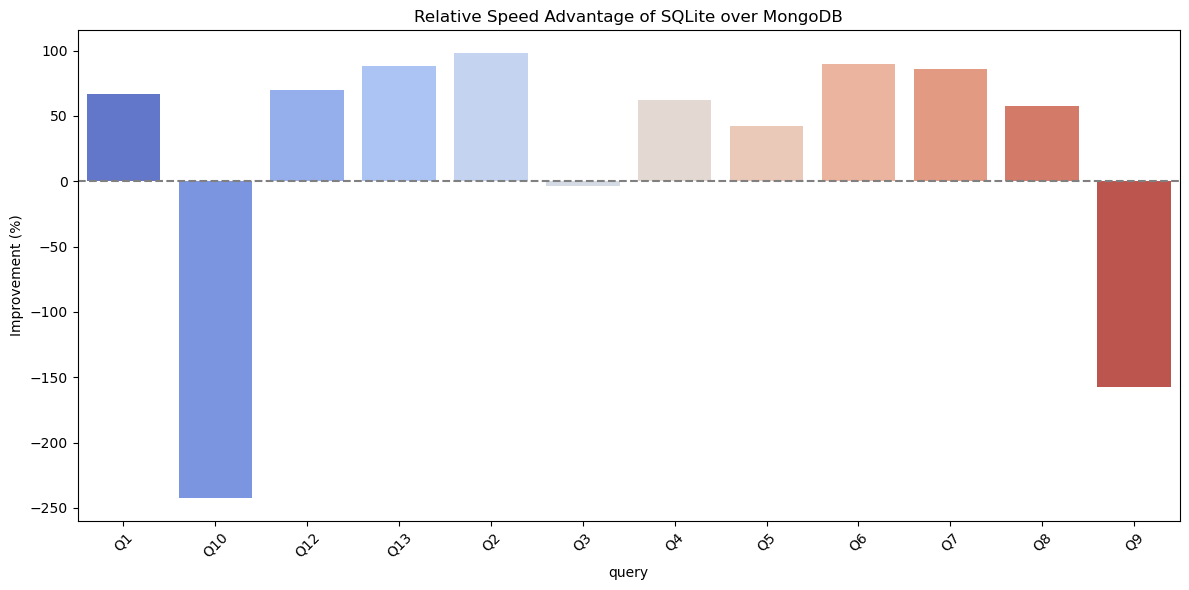

In [91]:
# Compute percentage improvement
summary = df.pivot(index="query", columns="db", values="mean_time").reset_index()
summary["pct_improvement"] = 100 * (summary["MongoDB"] - summary["SQLite"]) / summary["MongoDB"]

# df_sorted_queries = summary.sort_values("query")
# df_sorted_gap = summary.sort_values("pct_improvement", ascending=False)

summary = summary.sort_values("query")

# Display summary table
summary_formatted = summary[["query", "SQLite", "MongoDB", "pct_improvement"]].round(3)
summary_formatted.columns = ["Query", "SQLite Time (s)", "MongoDB Time (s)", "% Faster (SQLite)"]
display(summary_formatted)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=summary, x="query", y="pct_improvement", palette="coolwarm")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Relative Speed Advantage of SQLite over MongoDB")
plt.ylabel("Improvement (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


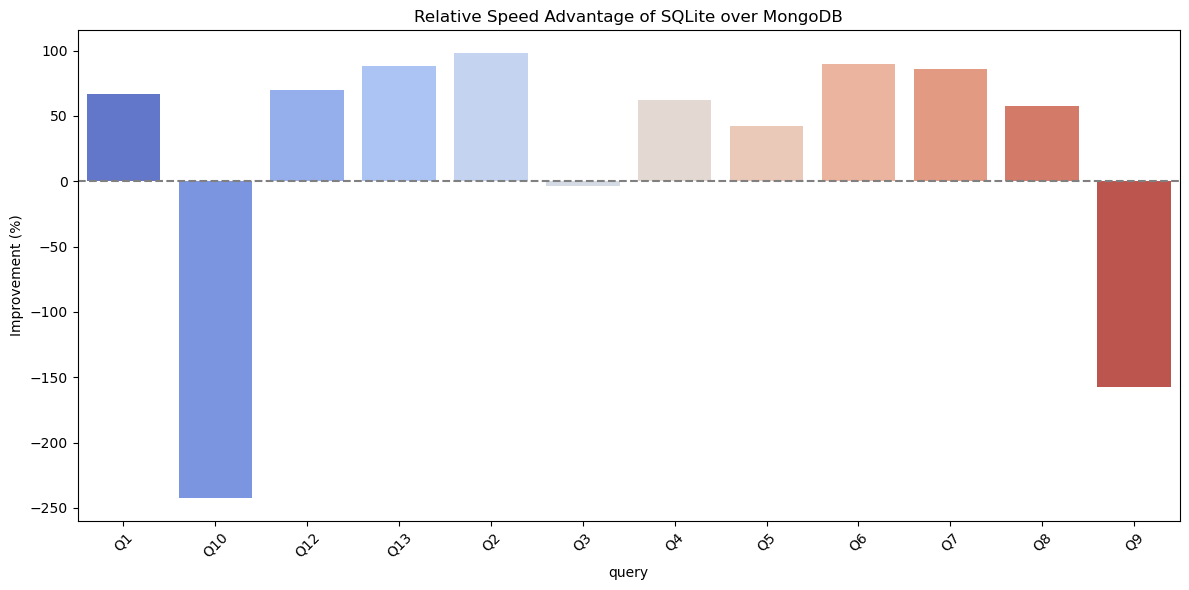

In [93]:
df_sorted = summary.sort_values("query")
# Sort by percentage improvement
# df_sorted = summary.sort_values("pct_improvement", ascending=False)

# Barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="query", y="pct_improvement", palette="coolwarm")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Relative Speed Advantage of SQLite over MongoDB")
plt.ylabel("Improvement (%)")
plt.xticks(rotation=45)
plt.tight_layout()